In [6]:
import SimpleITK as sitk
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import matplotlib.colors as mcolors
from utils import get_evaluation_data_from_paths, get_masked_scores, get_precision_recall_curve, get_local_precision_recall, get_average_precision, get_dscv
from matplotlib import cm

import seaborn as sns

In [7]:
path_dataset = '/path/to/dataset/here'

In [8]:
sns.set(rc = {'figure.figsize':(5,5), 'savefig.dpi': 200, 'figure.dpi': 200})

In [9]:
def plot_seg(background: np.array, seg: np.array, ref_seg:np.array, cut_coords: tuple, axs=None, axial=True, plot_background=True, color='g', label='', annotation=None, norm_background=False):
    
    size = 50
    overflow_min = [min(c - size, 0) for c in cut_coords]
    overflow_max = [max(c + size -s, 0) for c, s in zip(cut_coords, seg.shape)]
    max_axes = [min(c + size - o, s) for c, s, o in zip(cut_coords, seg.shape, overflow_min)]
    min_axes = [max(c - size - o, 0) for c, o in zip(cut_coords, overflow_max)]

    if axial:
        if plot_background:
            if norm_background:
                map_colorbar = axs.imshow(background[
                    cut_coords[2],
                    min_axes[1]:max_axes[1], 
                    min_axes[0]:max_axes[0]], cmap='gray',
                    vmin=0, vmax=1)
            else:
                map_colorbar = axs.imshow(background[
                    cut_coords[2],
                    min_axes[1]:max_axes[1], 
                    min_axes[0]:max_axes[0]], cmap='gray')
            axs.imshow(ref_seg[
                cut_coords[2],
                min_axes[1]:max_axes[1], 
                min_axes[0]:max_axes[0]], alpha=0.5*ref_seg[
                cut_coords[2],
                min_axes[1]:max_axes[1], 
                min_axes[0]:max_axes[0]], cmap='OrRd')
#             axs.axvline(x=cut_coords[0]-min_axes[0],color='white', linestyle=':')
#             axs.axhline(y=cut_coords[1]-min_axes[1],color='white', linestyle=':')
            axs.invert_yaxis()
            if annotation is not None:

                axs.annotate(annotation + ' Axial', (5, 5), color='white', fontsize='xx-large', backgroundcolor='black')
        else:
            map_colorbar = None
        axs.contour(seg[
                cut_coords[2],
                min_axes[1]:max_axes[1], 
                min_axes[0]:max_axes[0]], colors=color, levels=[0.5], linewidths=2)
    else:
        if plot_background:
            if norm_background:
                map_colorbar = axs.imshow(background[
                    min_axes[2]:max_axes[2],
                    cut_coords[1],
                    min_axes[0]:max_axes[0]], cmap='gray',
                    vmin=0, vmax=1)
            else:
                map_colorbar = axs.imshow(background[
                    min_axes[2]:max_axes[2],
                    cut_coords[1],
                    min_axes[0]:max_axes[0]], cmap='gray')
            axs.imshow(ref_seg[
                min_axes[2]:max_axes[2],
                cut_coords[1],
                min_axes[0]:max_axes[0]], alpha=0.5*ref_seg[
                min_axes[2]:max_axes[2],
                cut_coords[1],
                min_axes[0]:max_axes[0]], cmap='OrRd')
#             axs.axvline(x=cut_coords[2]-min_axes[2],color='white', linestyle=':')
#             axs.axhline(y=cut_coords[1]-min_axes[1],color='white', linestyle=':')
            axs.invert_yaxis()
            if annotation is not None:

                axs.annotate(annotation + ' Coronal', (5, 5), color='white', fontsize='xx-large', backgroundcolor='black')
        else:
            map_colorbar = None
        axs.contour(seg[
                min_axes[2]:max_axes[2],
                cut_coords[1],
                min_axes[0]:max_axes[0]], colors=color, levels=[0.5], linewidths=2)
    
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    axs.axis('off')
        
    return axs, map_colorbar

## Curve in methods

/tmp/ipykernel_454516/3640685899.py:70: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


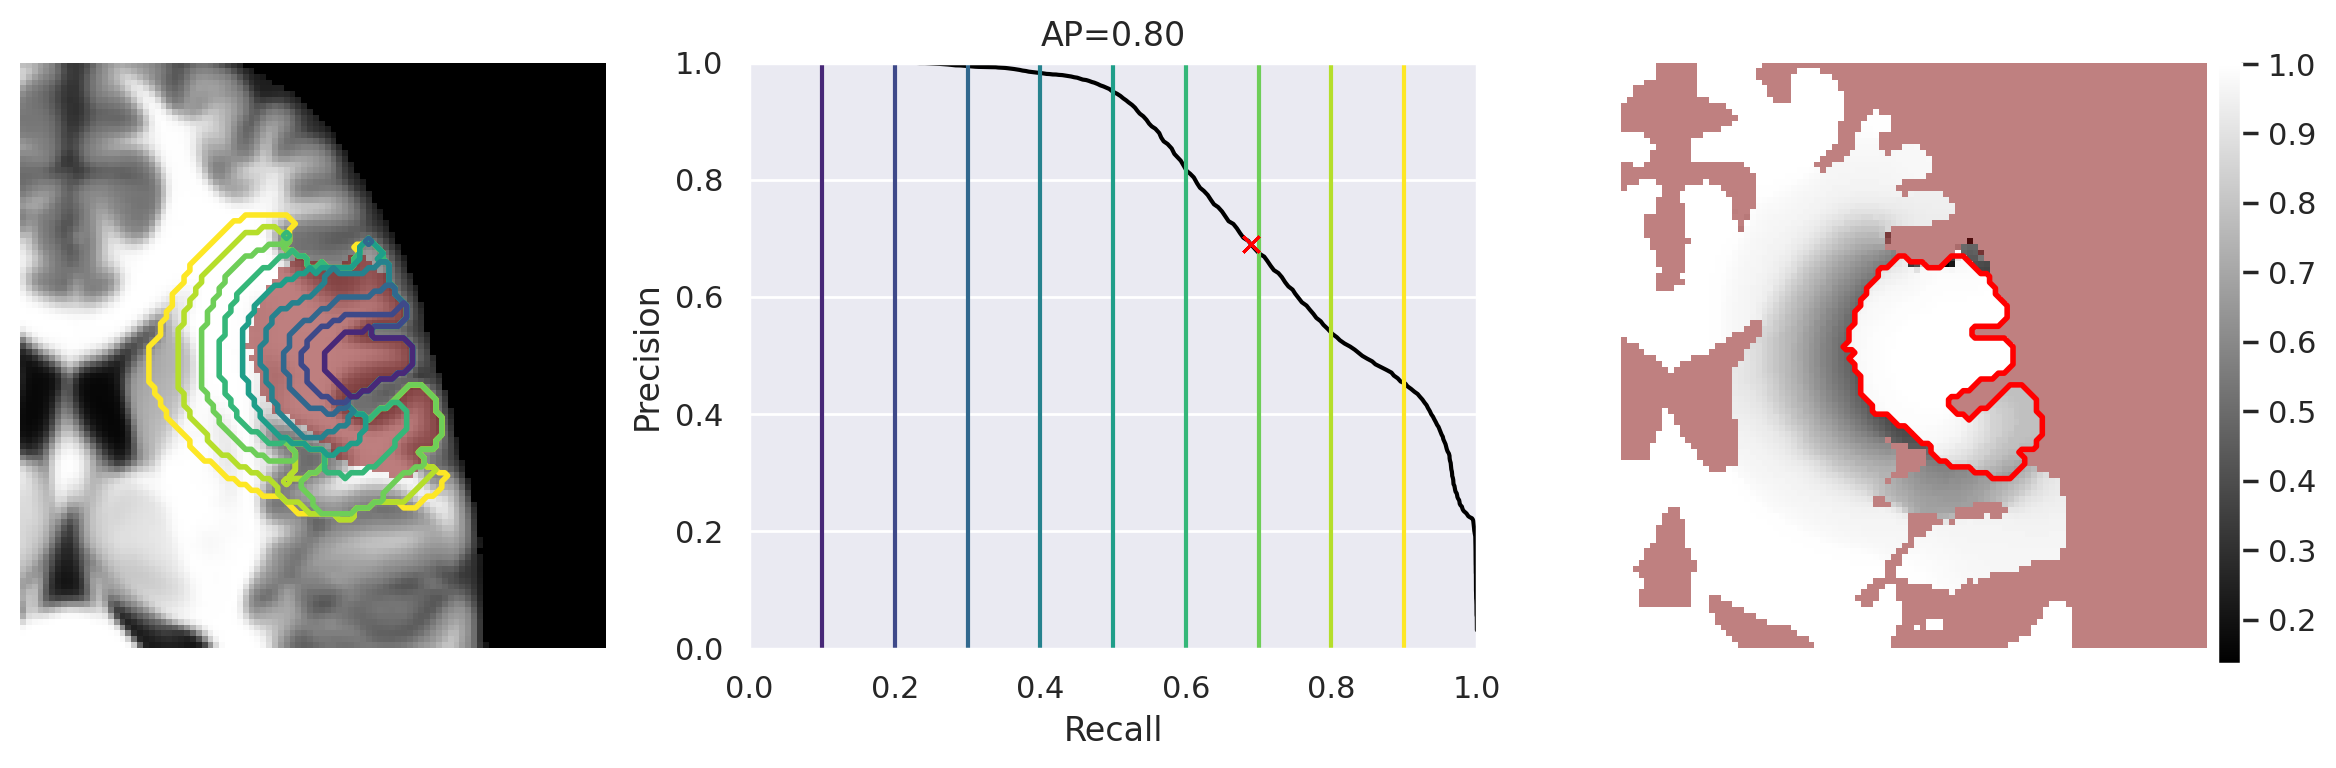

In [10]:
def plot_pr_curve(pat_name):
    reference_seg_path = os.path.join(path_dataset, f'{pat_name}/ATLAS/BASE_TUMOR_to_ATLAS_bspline.nii.gz')
    reference_seg = sitk.ReadImage(reference_seg_path)
    reference_arr = sitk.GetArrayFromImage(reference_seg > 0.5)

    prediction_path = os.path.join(path_dataset, f'{pat_name}/BASE/ranked_result.nii.gz')
    prediction_im = sitk.ReadImage(prediction_path)
    prediction_arr = sitk.GetArrayFromImage(prediction_im)

    background_im_path = '../resources/IITmean_t1.nii.gz'
    background_im = sitk.ReadImage(background_im_path)
    background_arr = sitk.GetArrayFromImage(background_im)

    tissue_seg_path = os.path.join(path_dataset, f'{pat_name}/BASE/tissue_seg.nii.gz')
    tissue_seg = sitk.ReadImage(tissue_seg_path)
    inclusion_mask = sitk.GetArrayFromImage(tissue_seg > 0.5)
    
    reference_arr[inclusion_mask < 0.5] = 0
    values, reference_values = get_masked_scores(prediction_arr, reference_arr, inclusion_mask > 0.5)
    precision, recall, thresholds = get_precision_recall_curve(prediction_arr, reference_arr, inclusion_mask > 0.5)
    
    label_filter = sitk.LabelShapeStatisticsImageFilter()
    label_filter.Execute(reference_seg > 0.5)
    centroid = label_filter.GetCentroid(1)
    index = reference_seg.TransformPhysicalPointToIndex(centroid)
    prediction_array_inverted = 0 - prediction_arr
    axs = None

    recall_values = np.arange(0.1, 1.0, 0.1)
    recall_values = np.flip(recall_values)

    ap = get_average_precision(prediction_arr, reference_arr, inclusion_mask > 0.5)
    dscv = get_dscv(prediction_arr, reference_arr, inclusion_mask > 0.5)

    norm = mcolors.Normalize(vmin=0, vmax=len(recall_values))
    colors = [cm.viridis_r(norm(i)) for i in range(len(recall_values))]

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    plot_background = True

    ### PLOT thresholds on background image
    for (rec_thr, c) in zip(recall_values, colors):
        thr_index = np.argwhere(recall>rec_thr)[-1]
        thr = thresholds[thr_index]

        plot_seg(background_arr, prediction_array_inverted < thr, 
                       reference_arr, index, plot_background=plot_background, axs=axs[0], color=[c])
        plot_background = False

    ### PLOT curve
    axs[1].plot(recall, precision, color='black')
    for (rec_thr, c) in zip(recall_values, colors):
        axs[1].axvline(x=rec_thr, ymin=0, ymax=1, color=c)
        axs[1].plot([dscv], [dscv], 'x', color='red')
        axs[1].set_xlim(0,1)
        axs[1].set_ylim(0,1)
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].set_title(f'AP={ap:.2f}')


    prec_arr, recall_arr = get_local_precision_recall(prediction_arr, reference_arr, inclusion_mask > 0.5)
    comb_prec_rec = prec_arr
    comb_prec_rec[reference_arr < 0.5] = recall_arr[reference_arr < 0.5]
    plt_axs, map_colorbar = plot_seg(comb_prec_rec, reference_arr, inclusion_mask < 0.5, index, axs=axs[2], color=['red'])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0)
    cb_ax = fig.add_axes([.96,.15,.01,.75])
    fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)
    return fig

plot_pr_curve('pat_04')
plt.savefig('figures/precision_recall_curve.jpg')
plt.show()
plt.close()

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


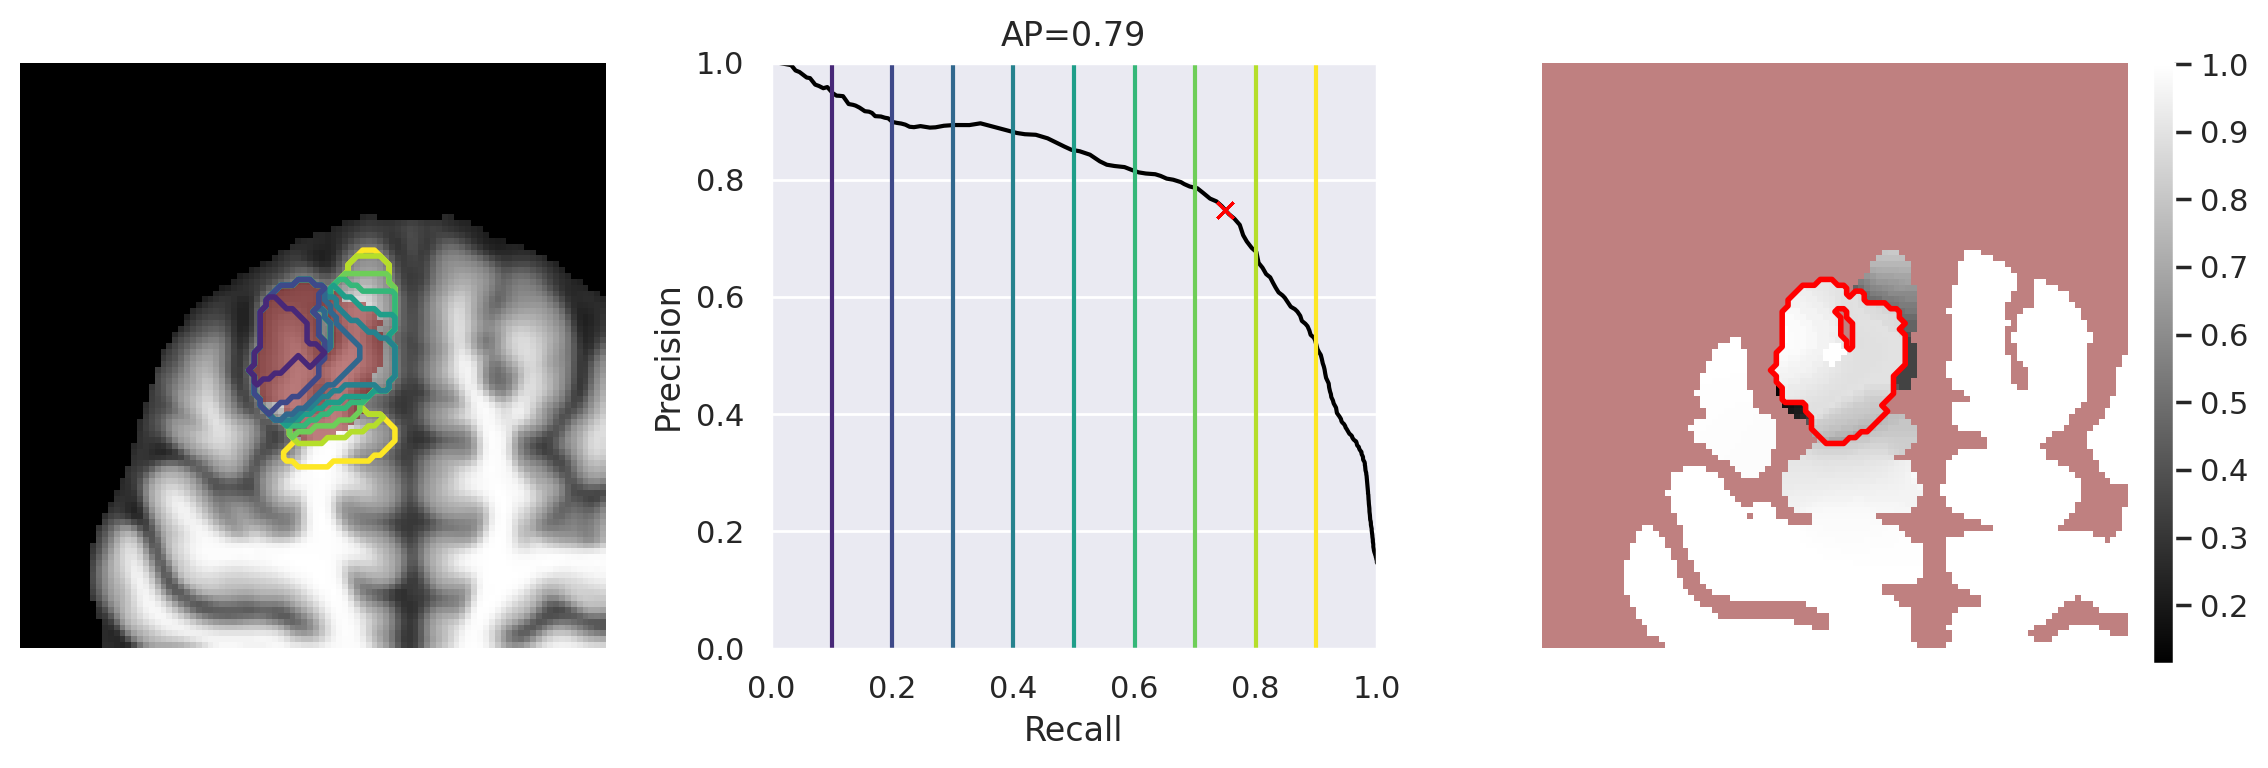

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


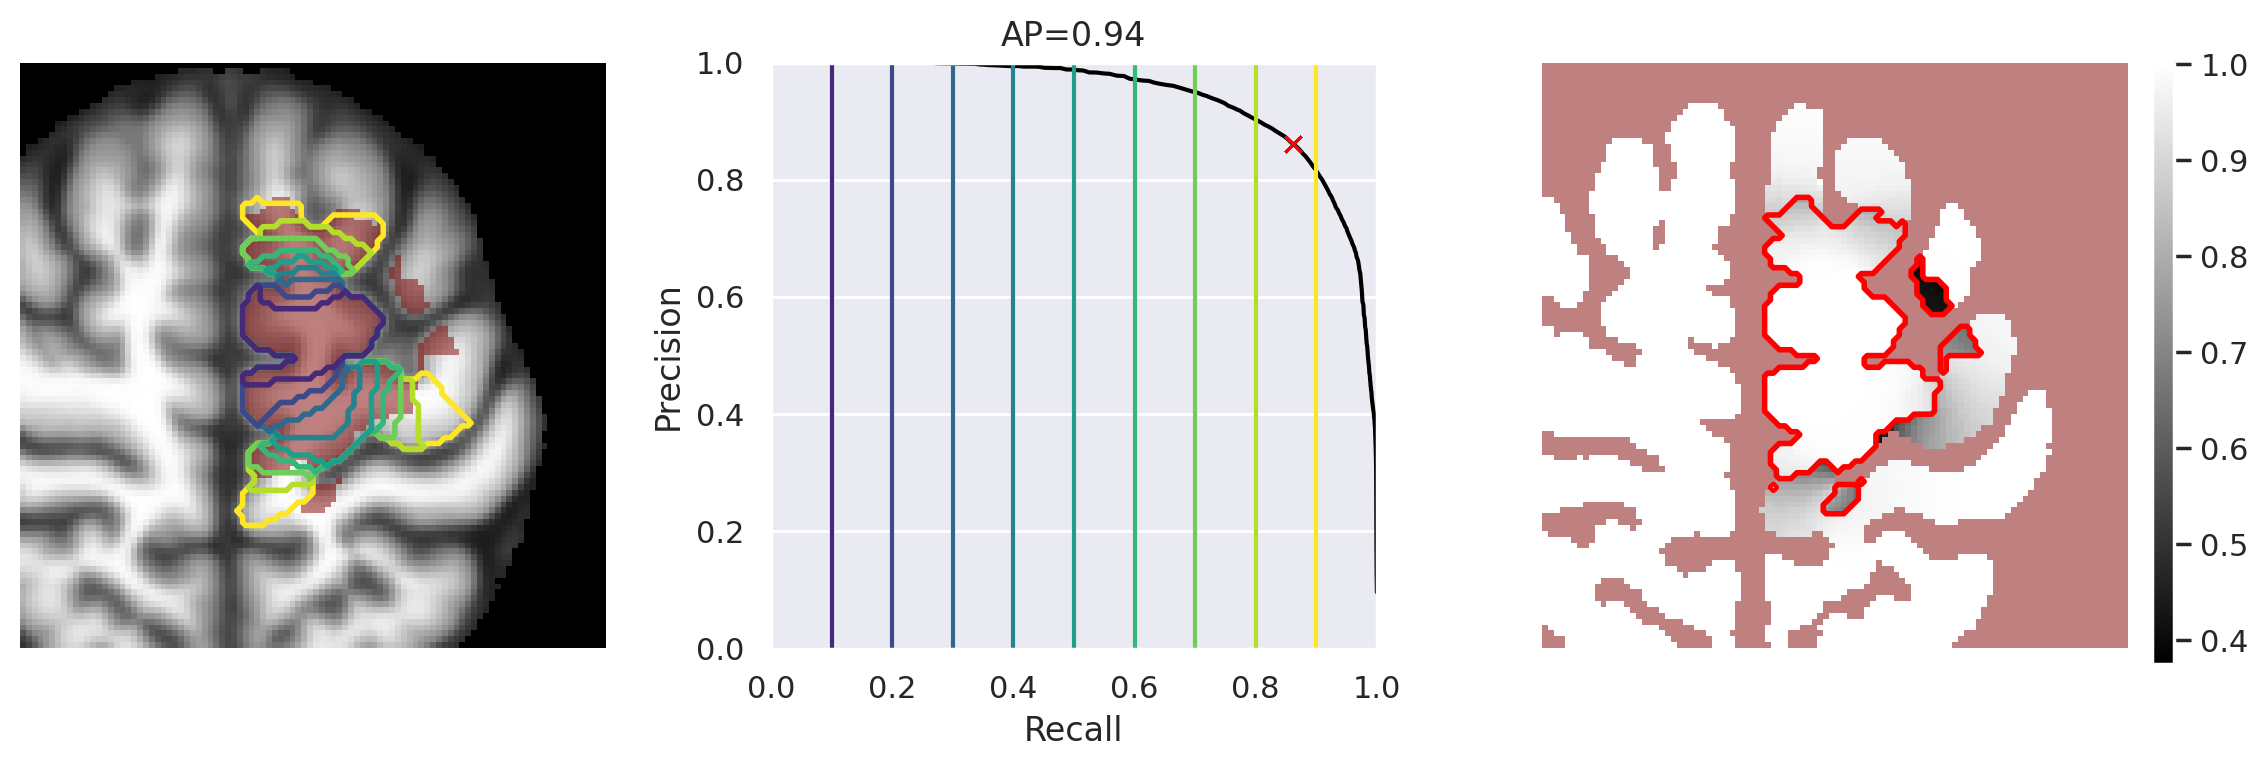

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


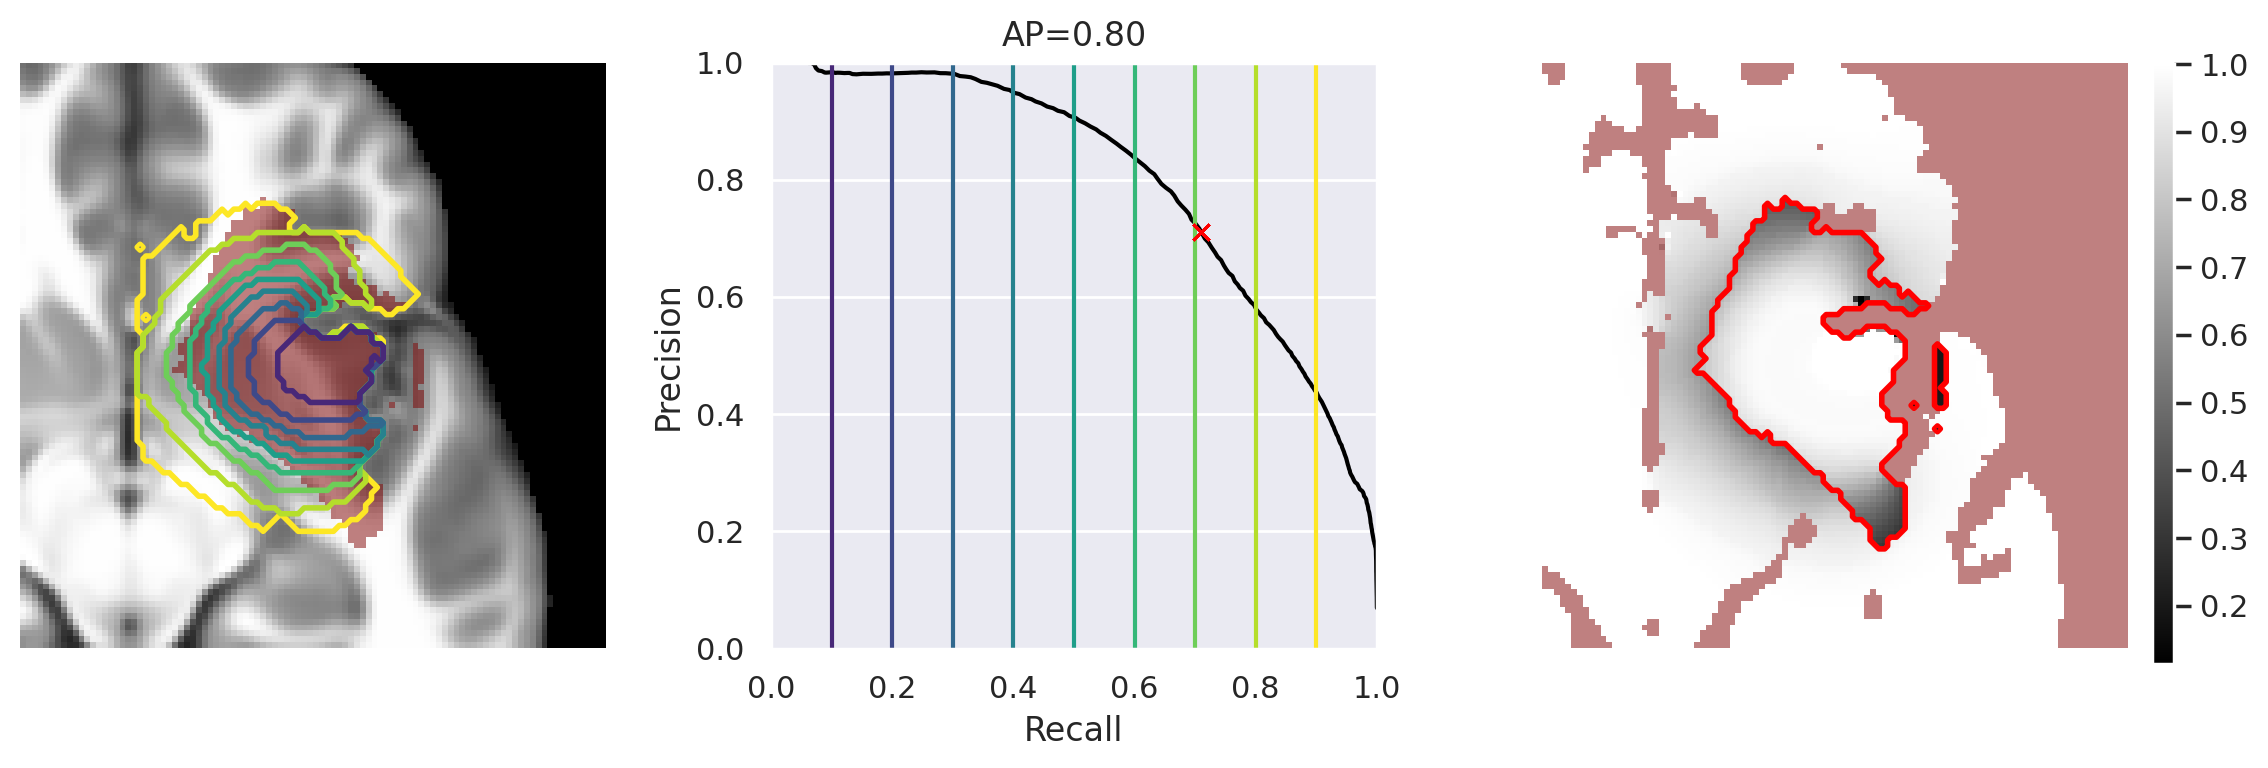

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


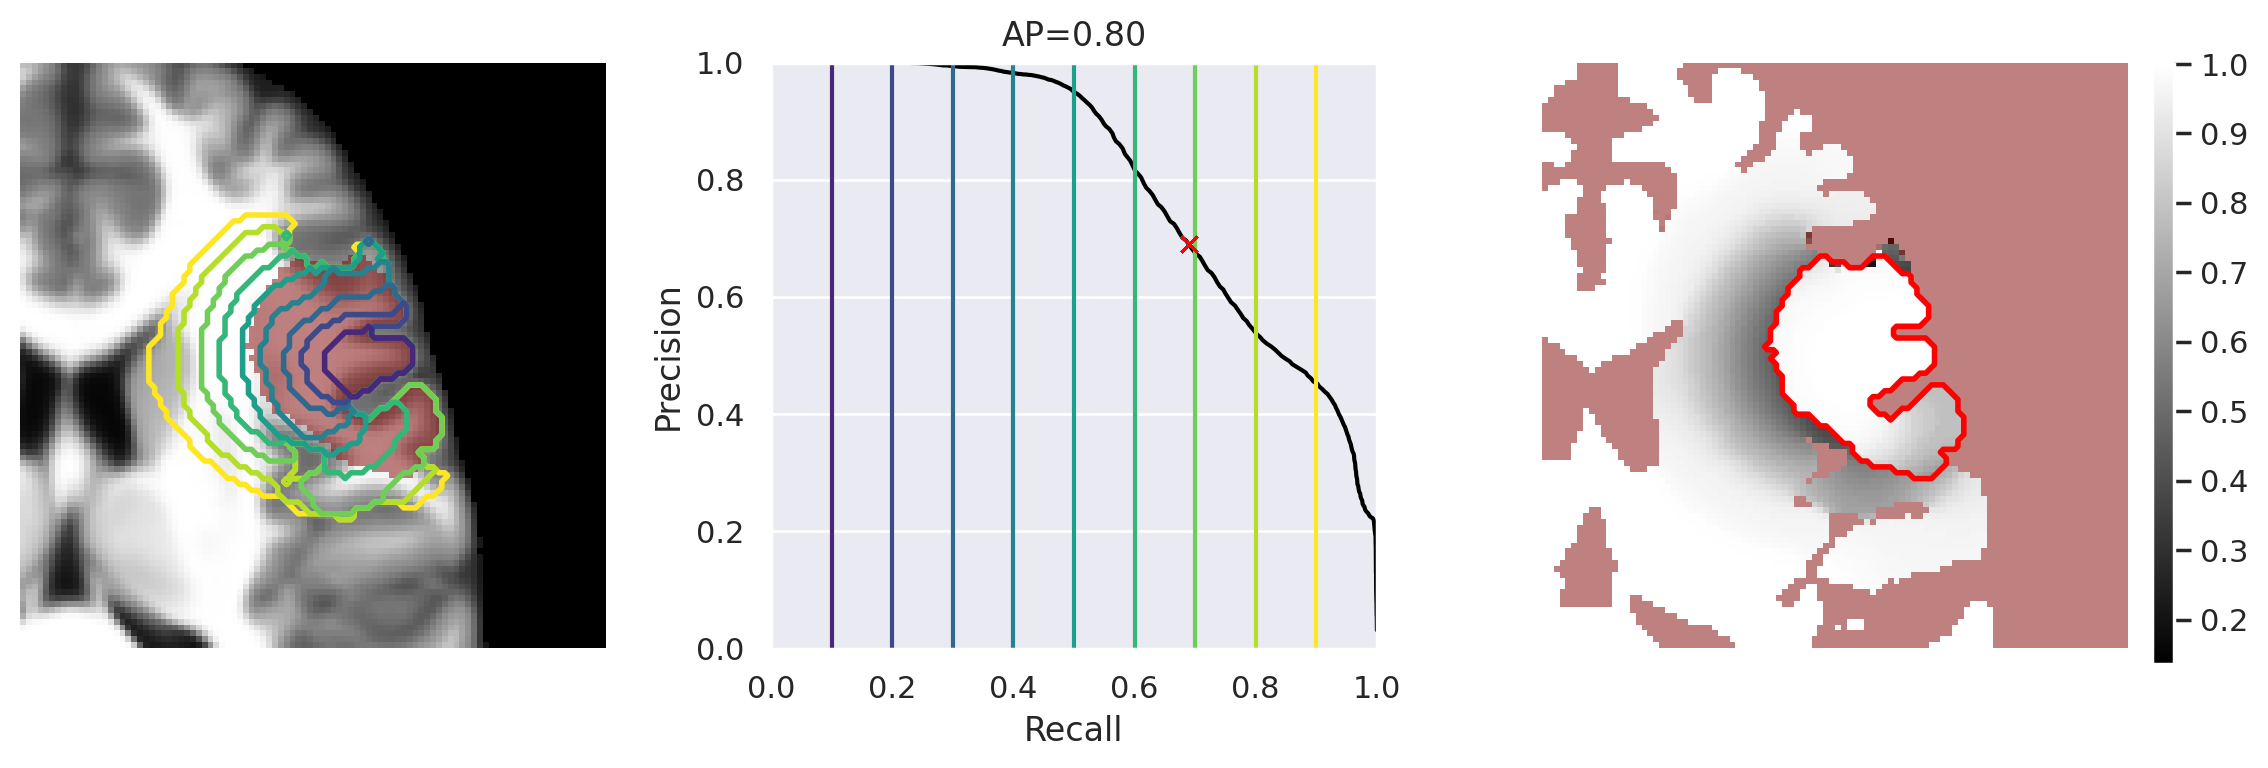

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


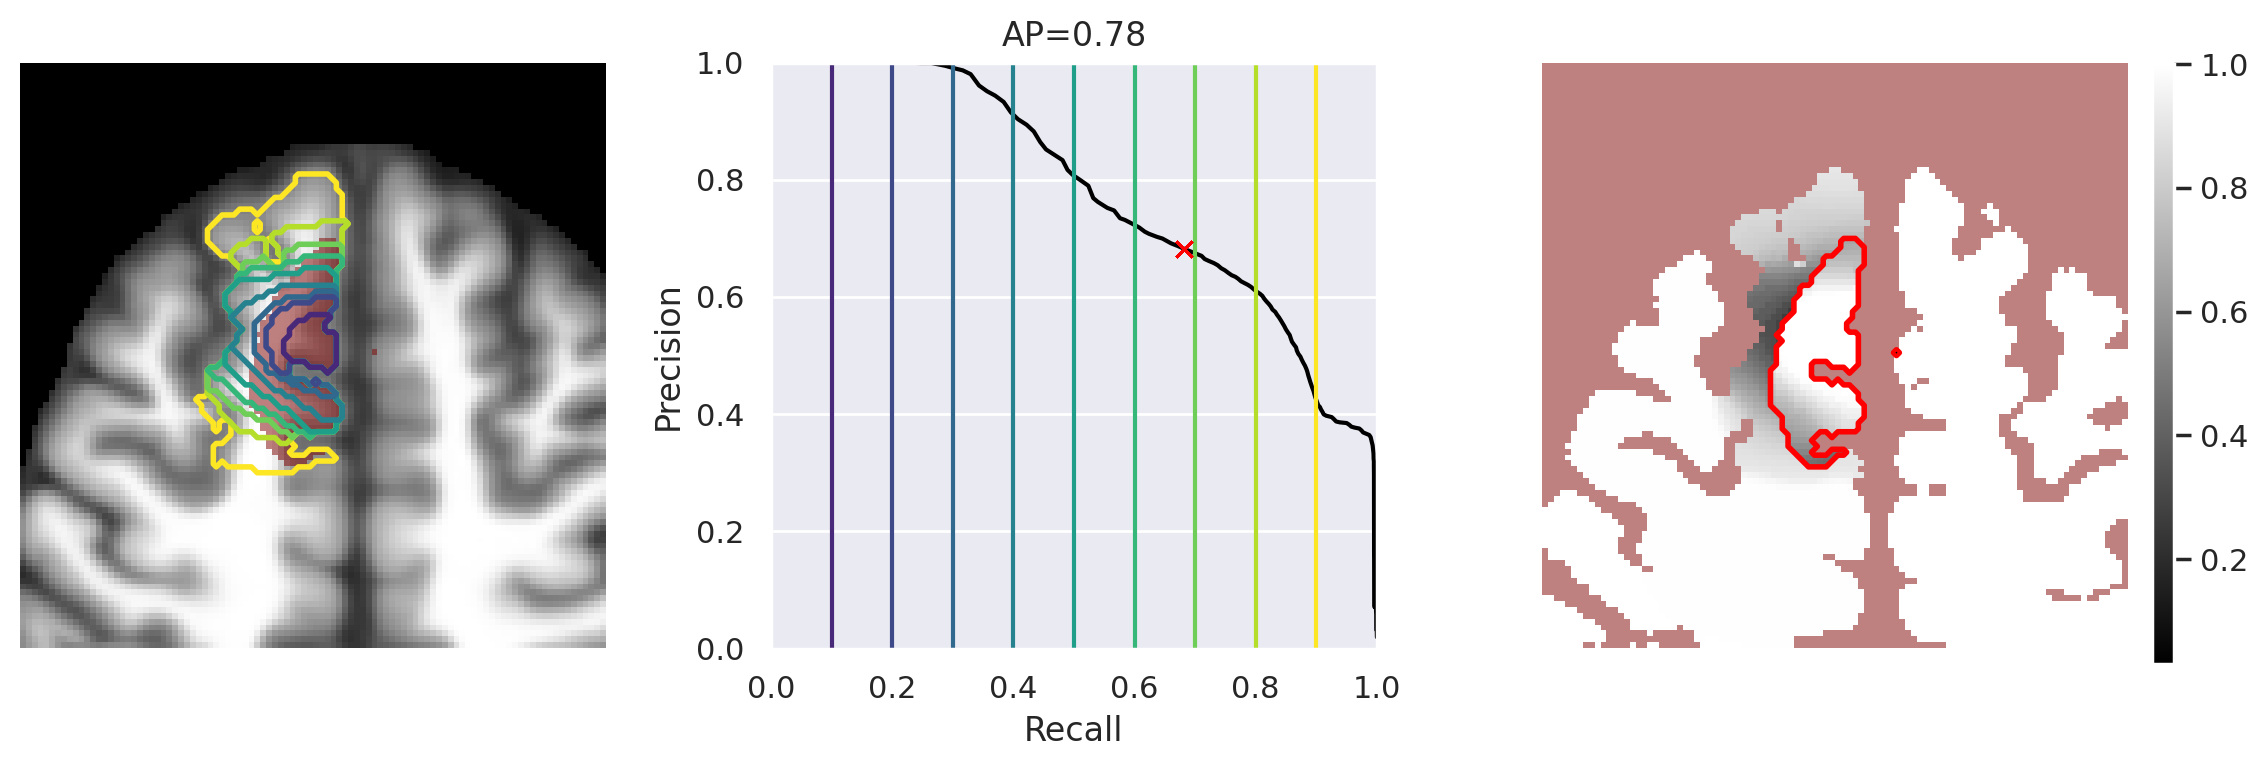

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


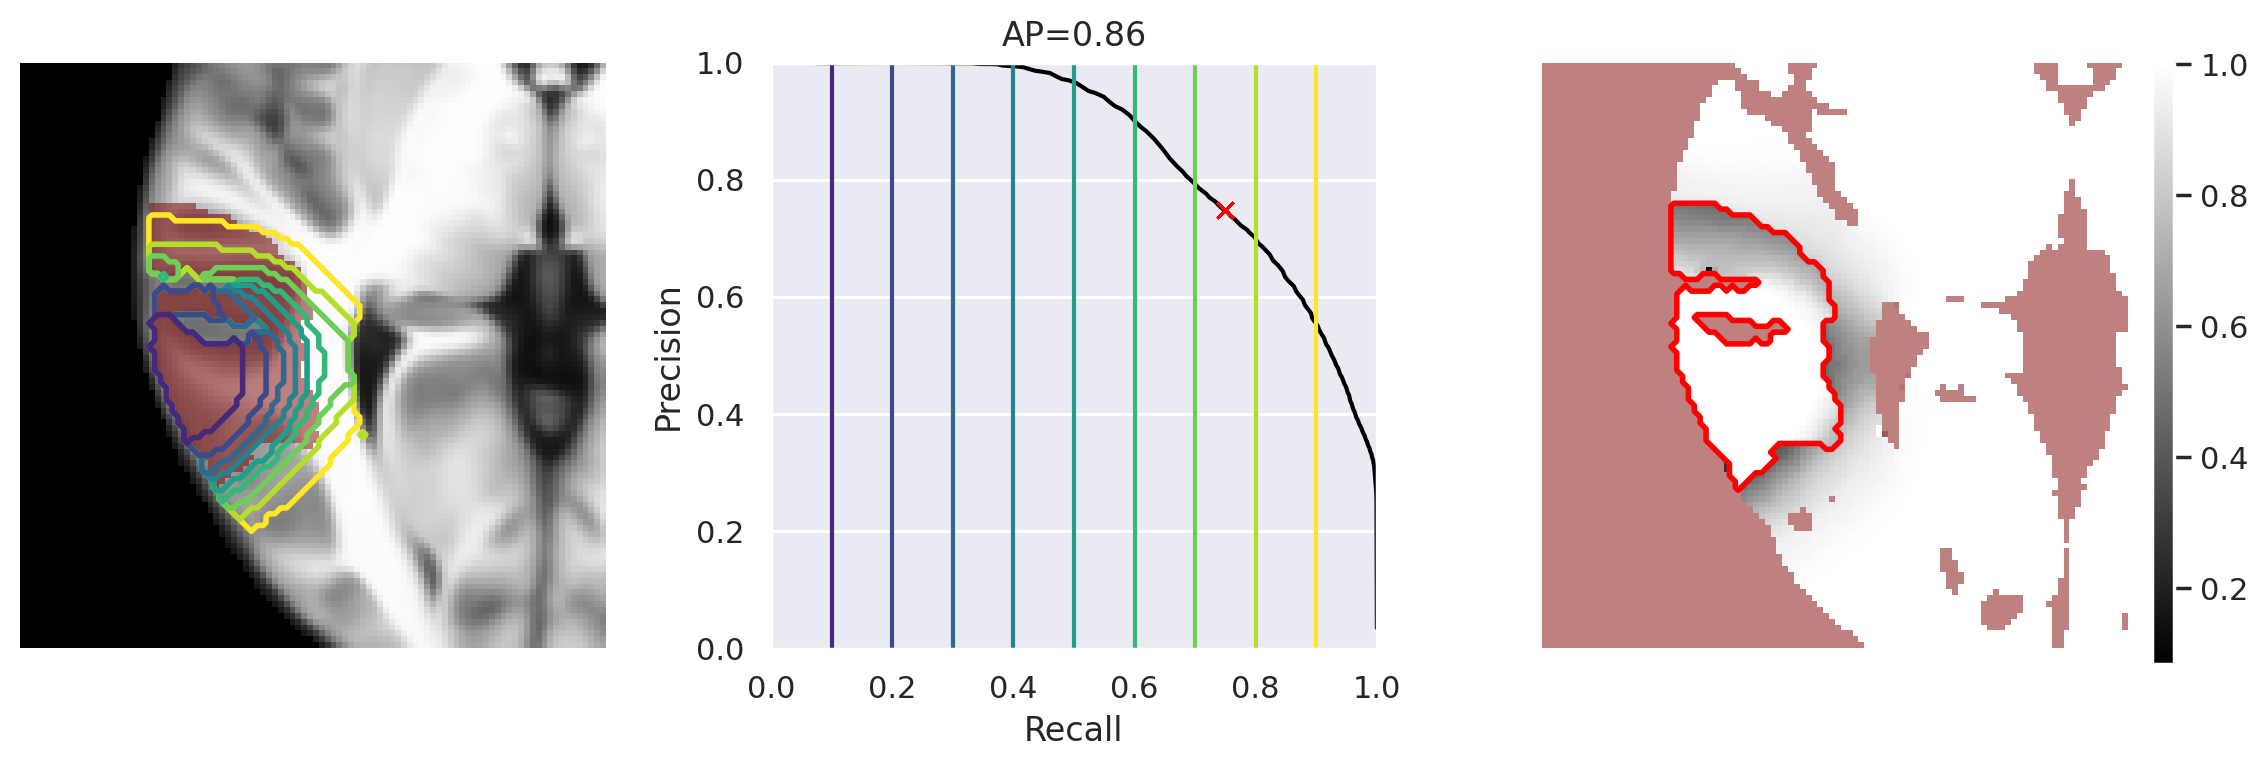

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


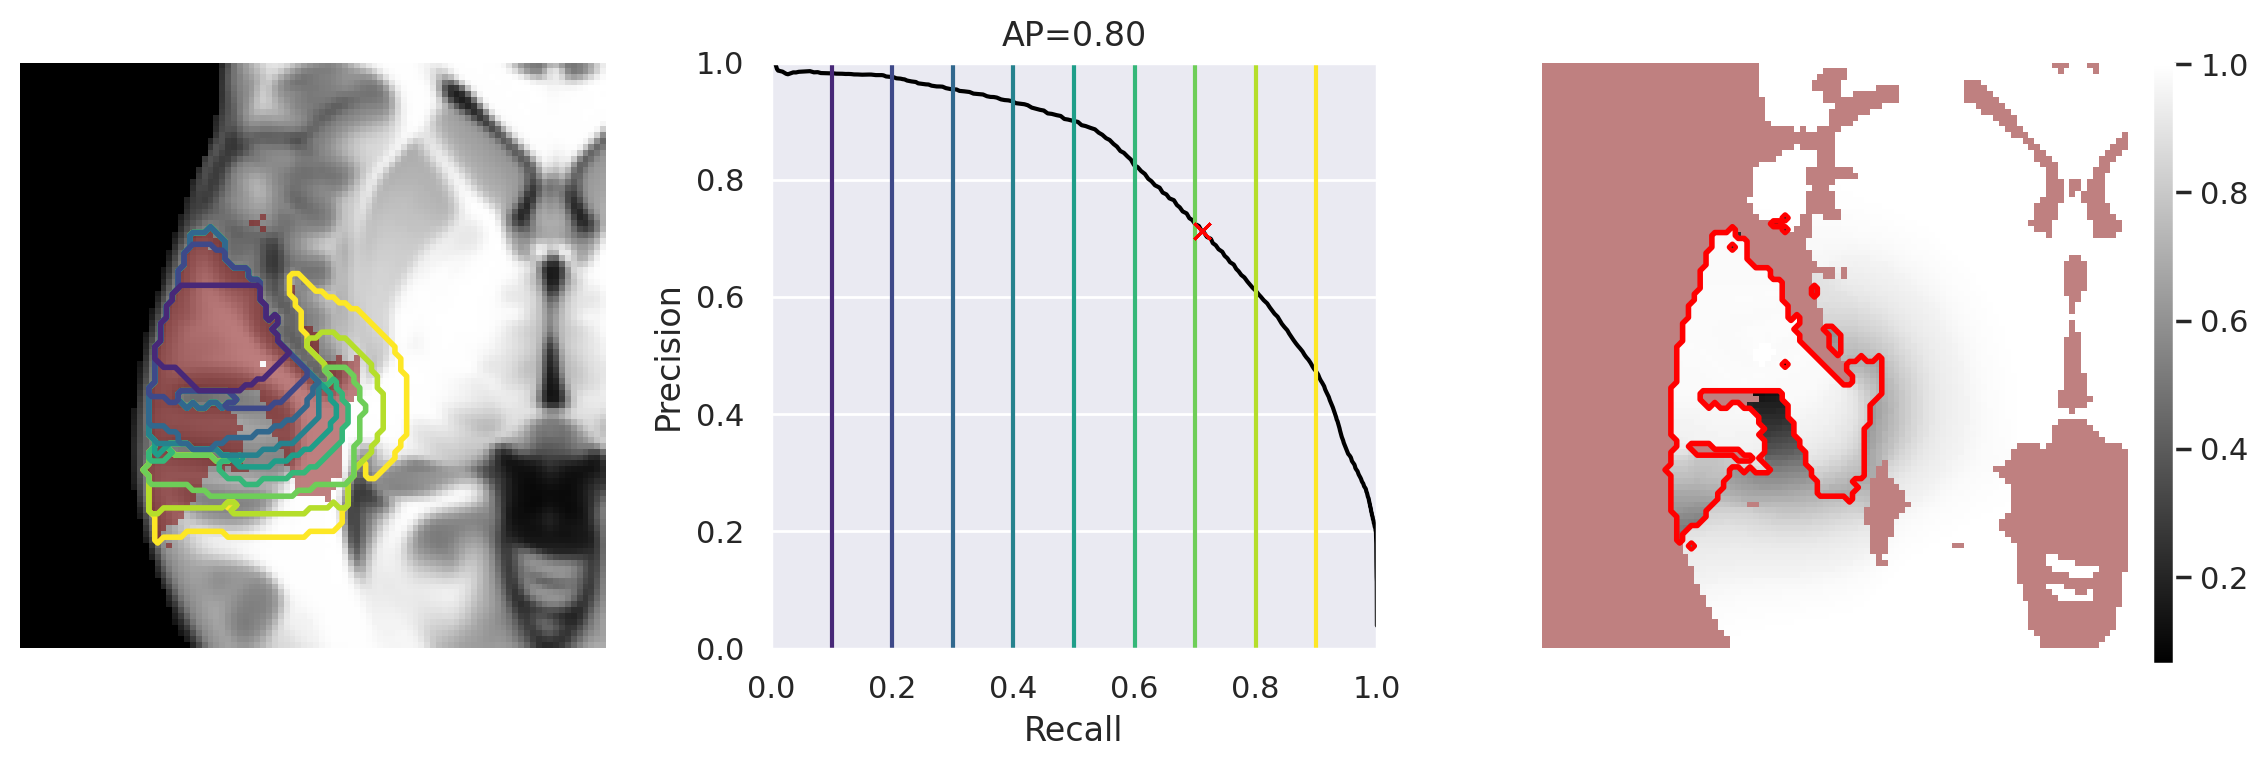

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


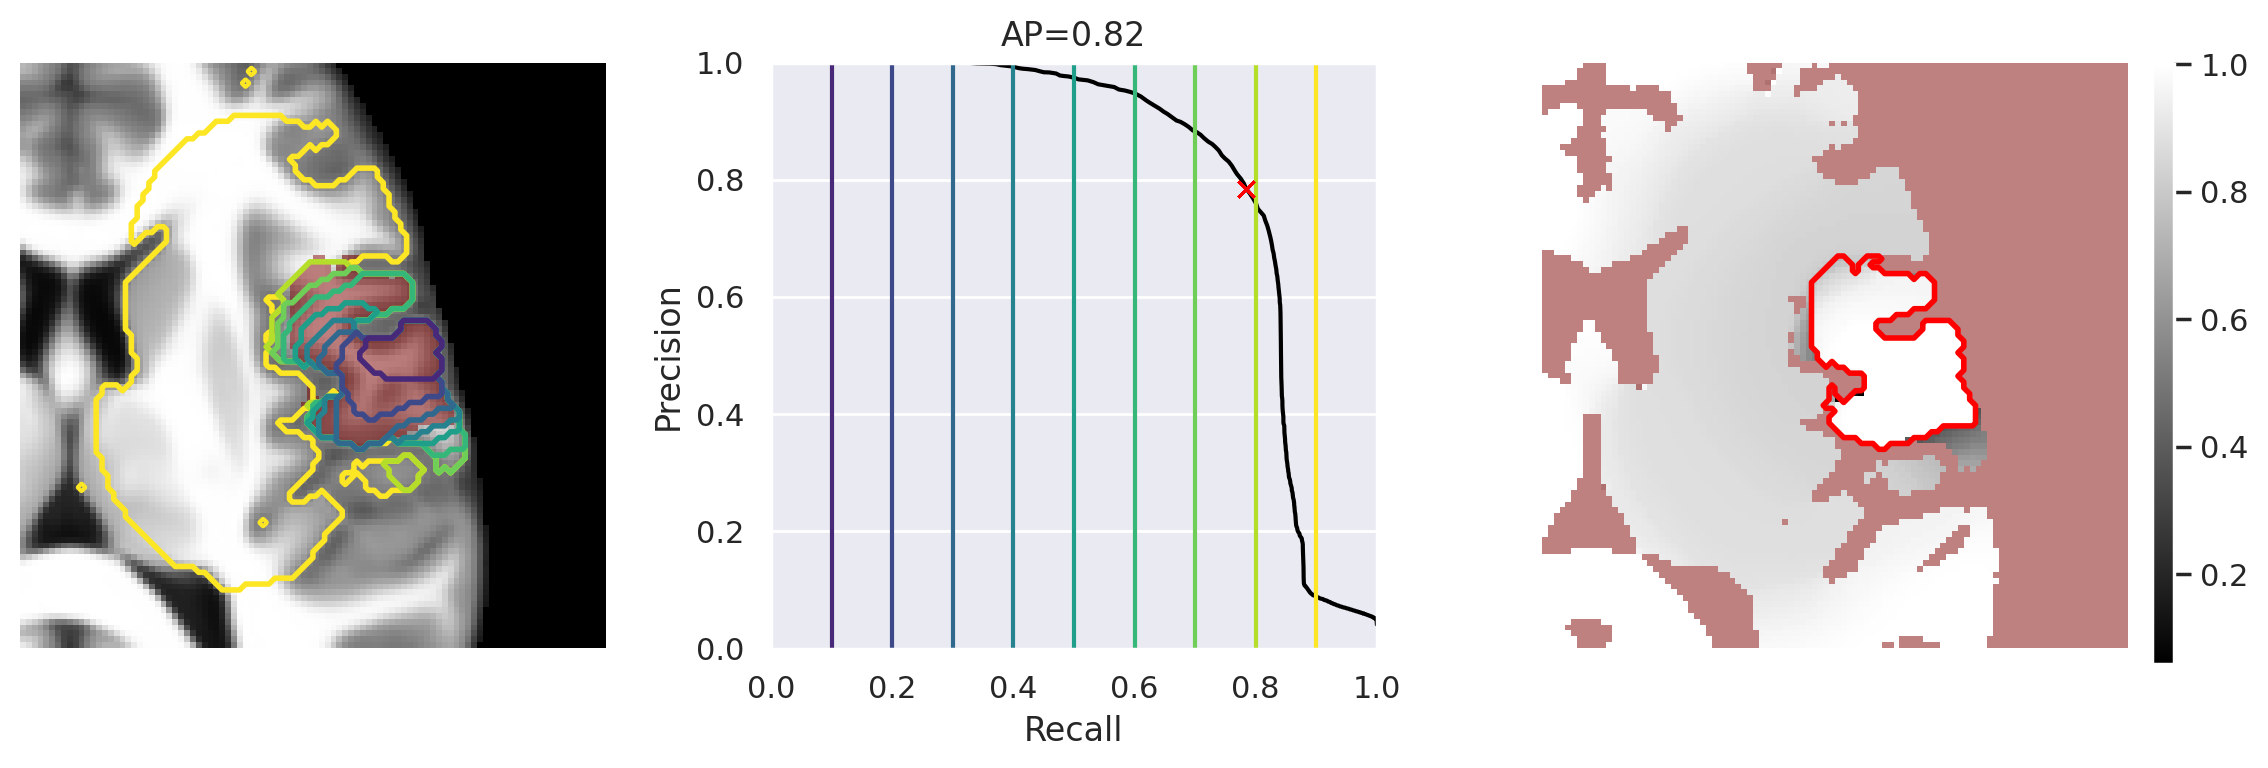

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


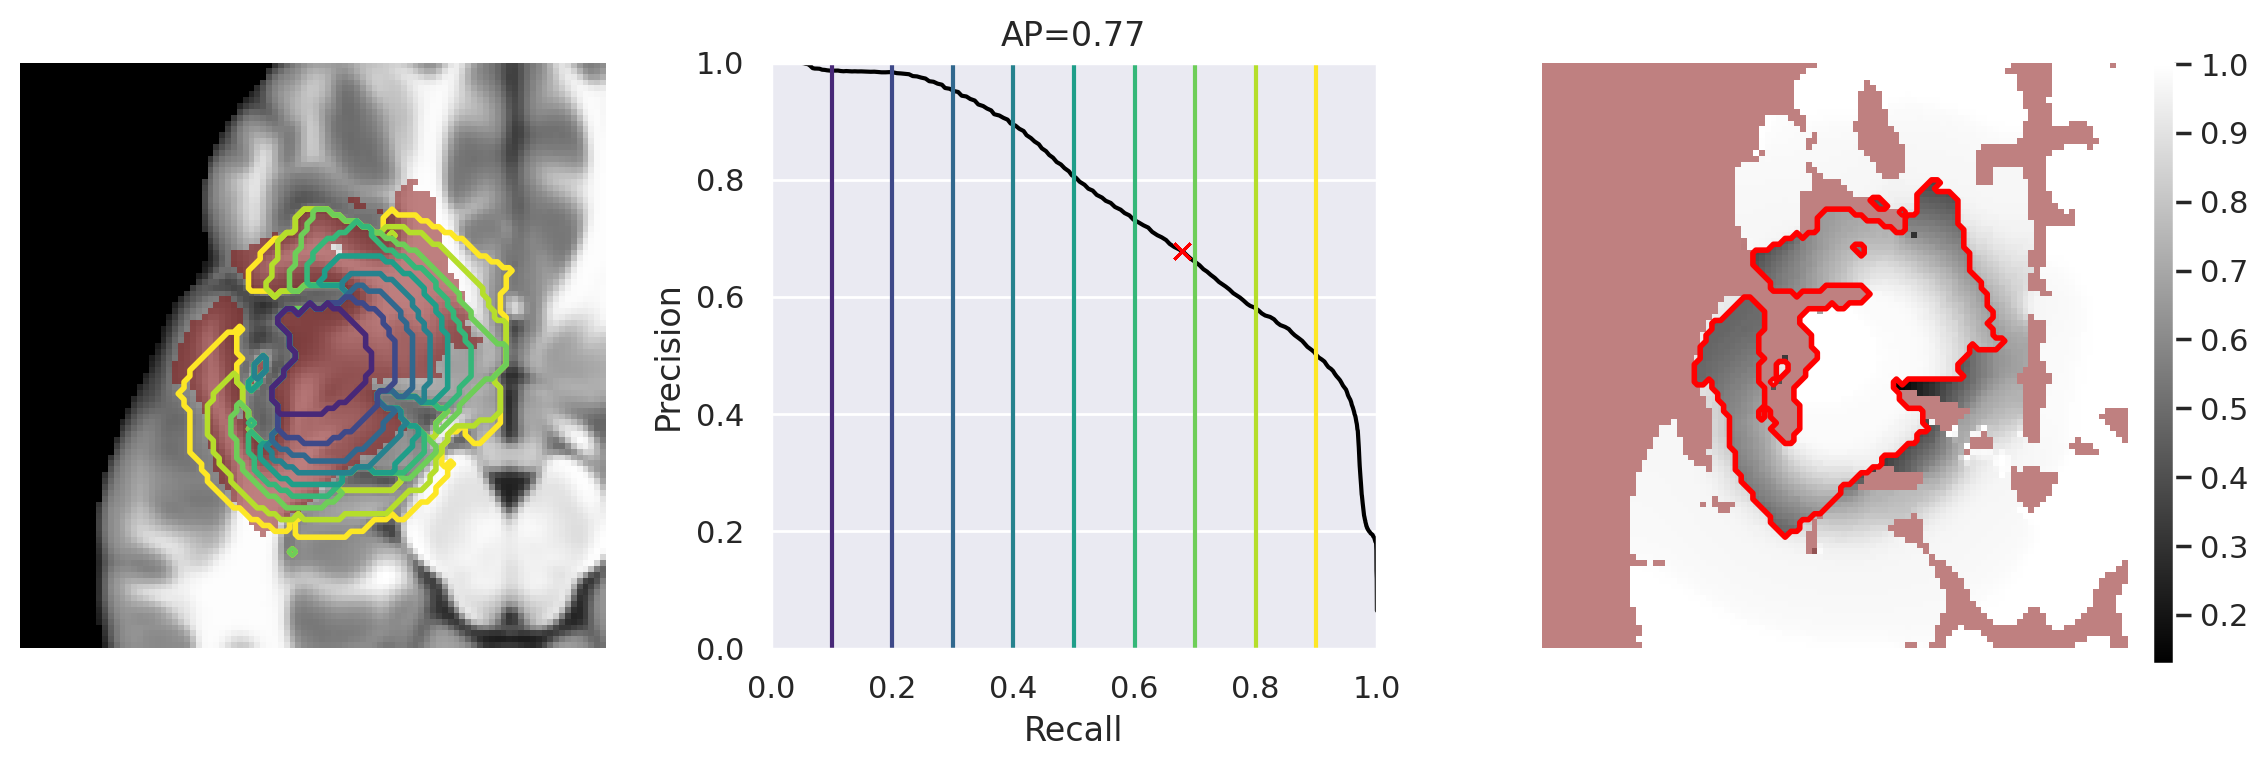

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


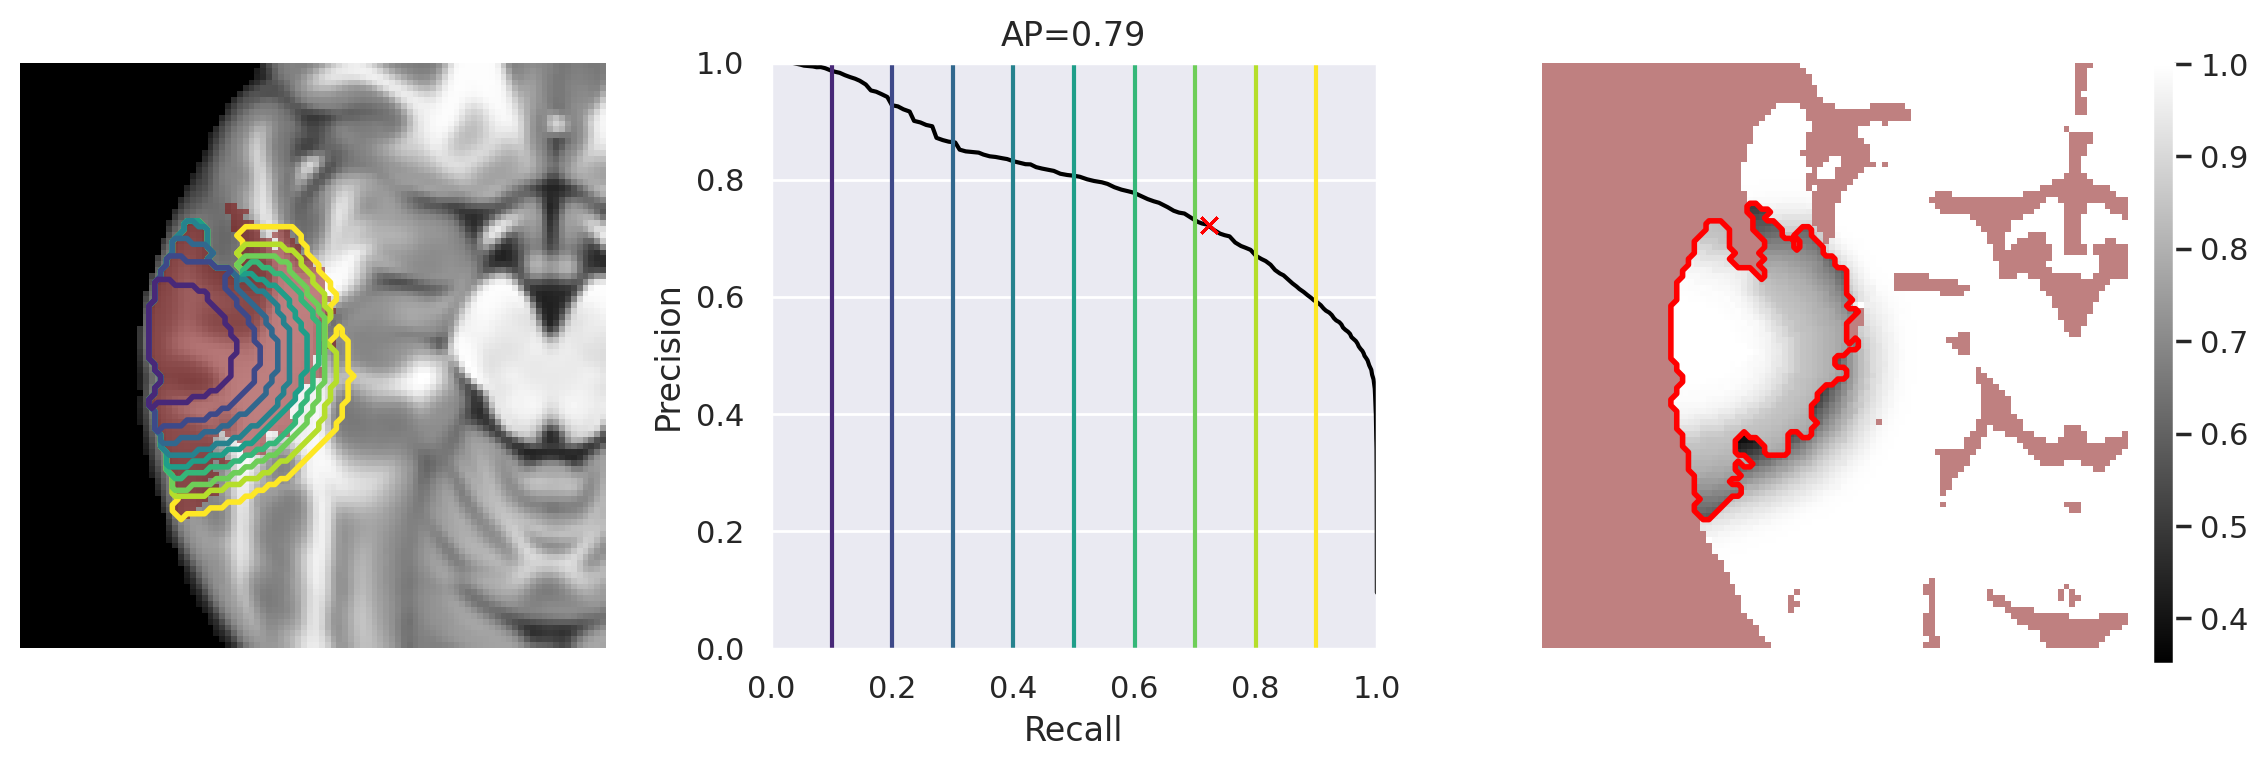

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


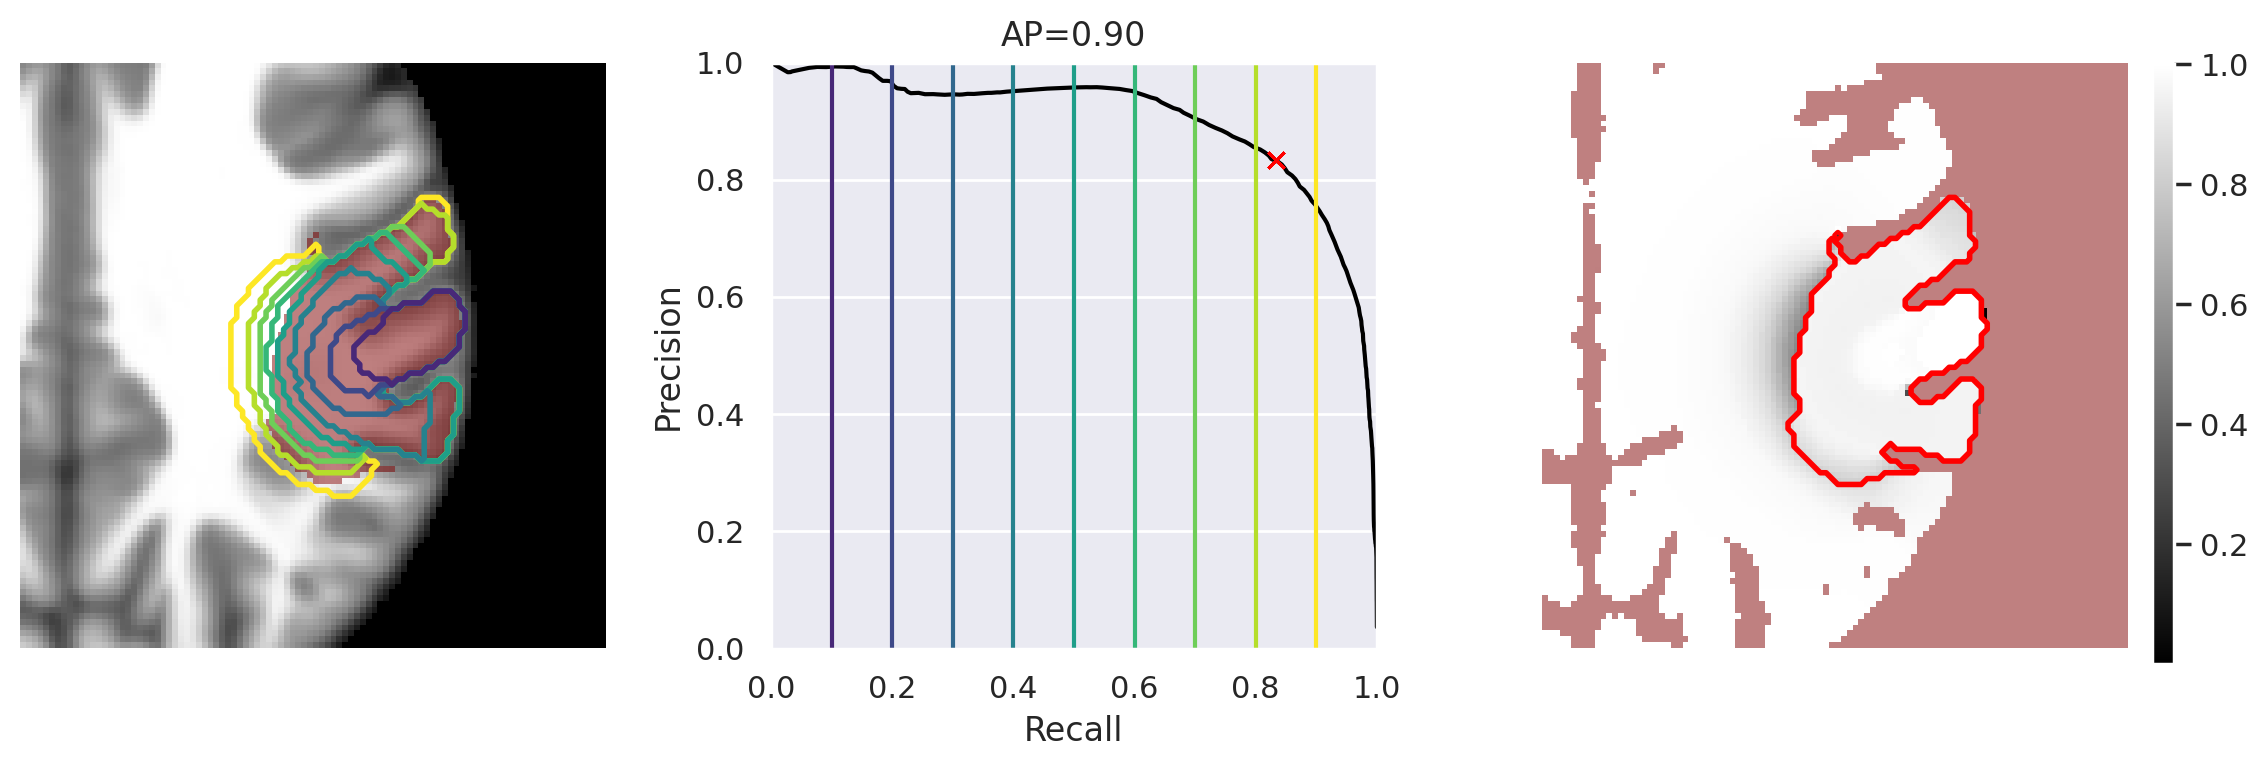

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


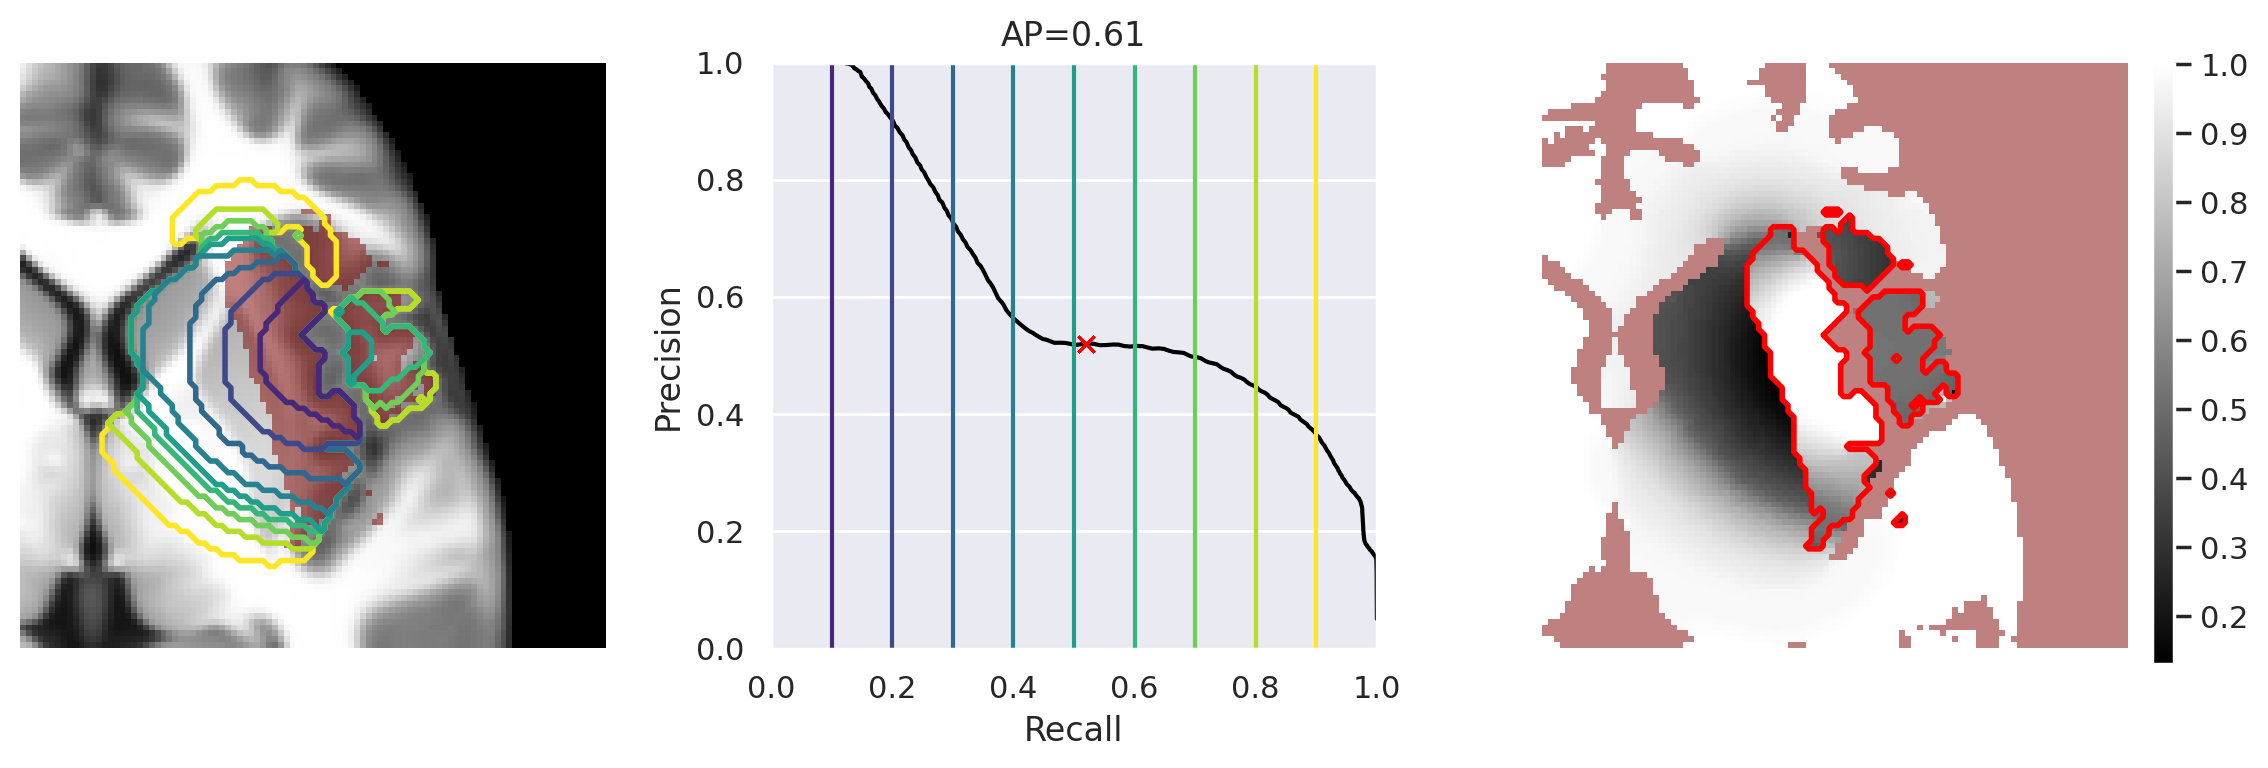

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


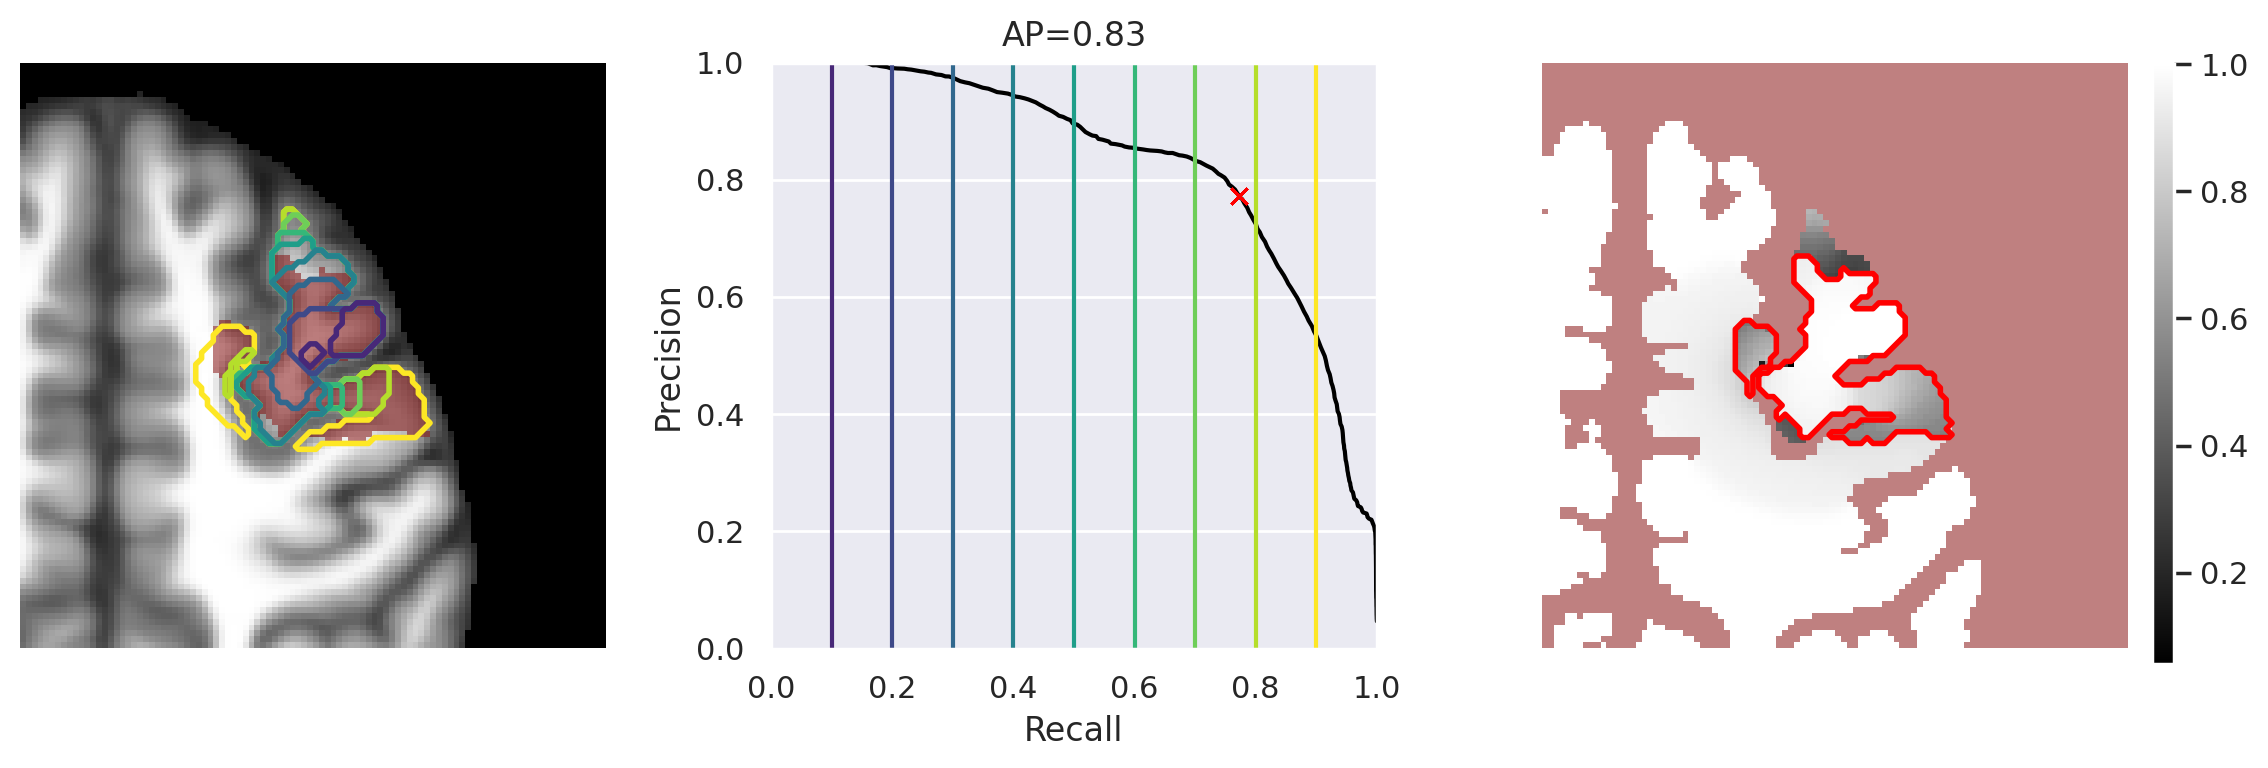

/tmp/ipykernel_3555535/2622542271.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


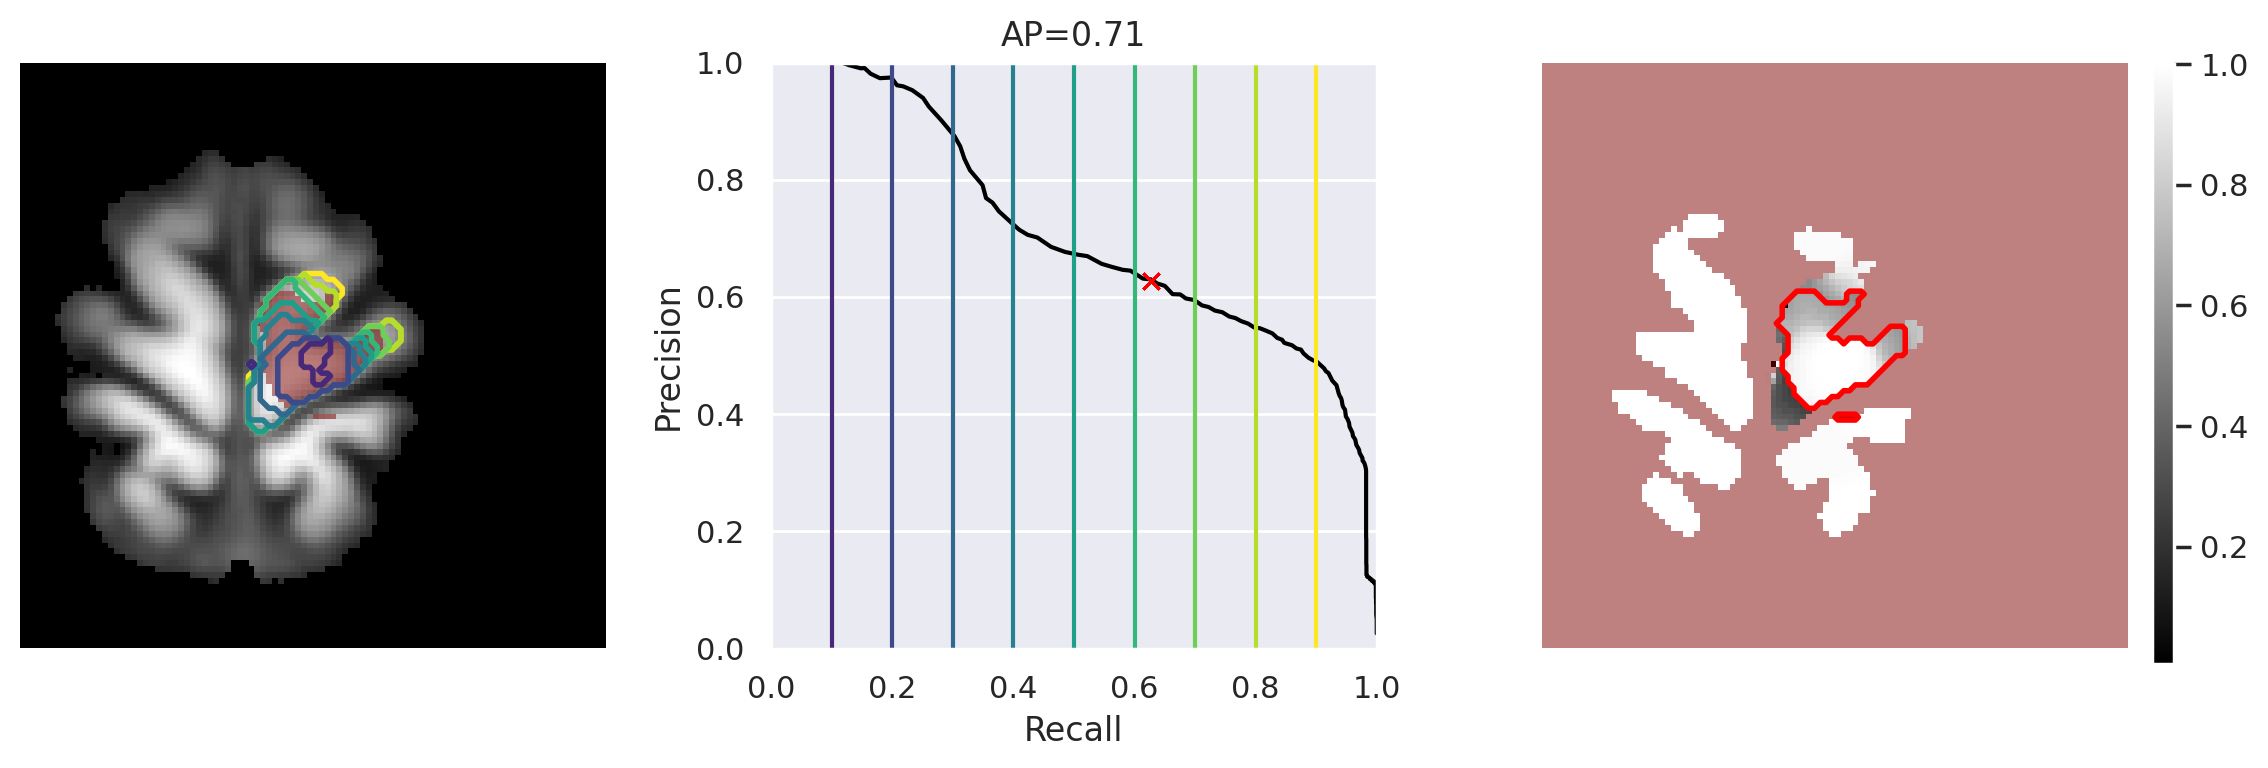

In [6]:
for pat_name in os.listdir(path_dataset):
    if not pat_name[0:3] == 'pat':
        continue
    plot_pr_curve(pat_name)
    plt.show()
    plt.close()

## Curve in results

/tmp/ipykernel_454516/3059912810.py:78: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)


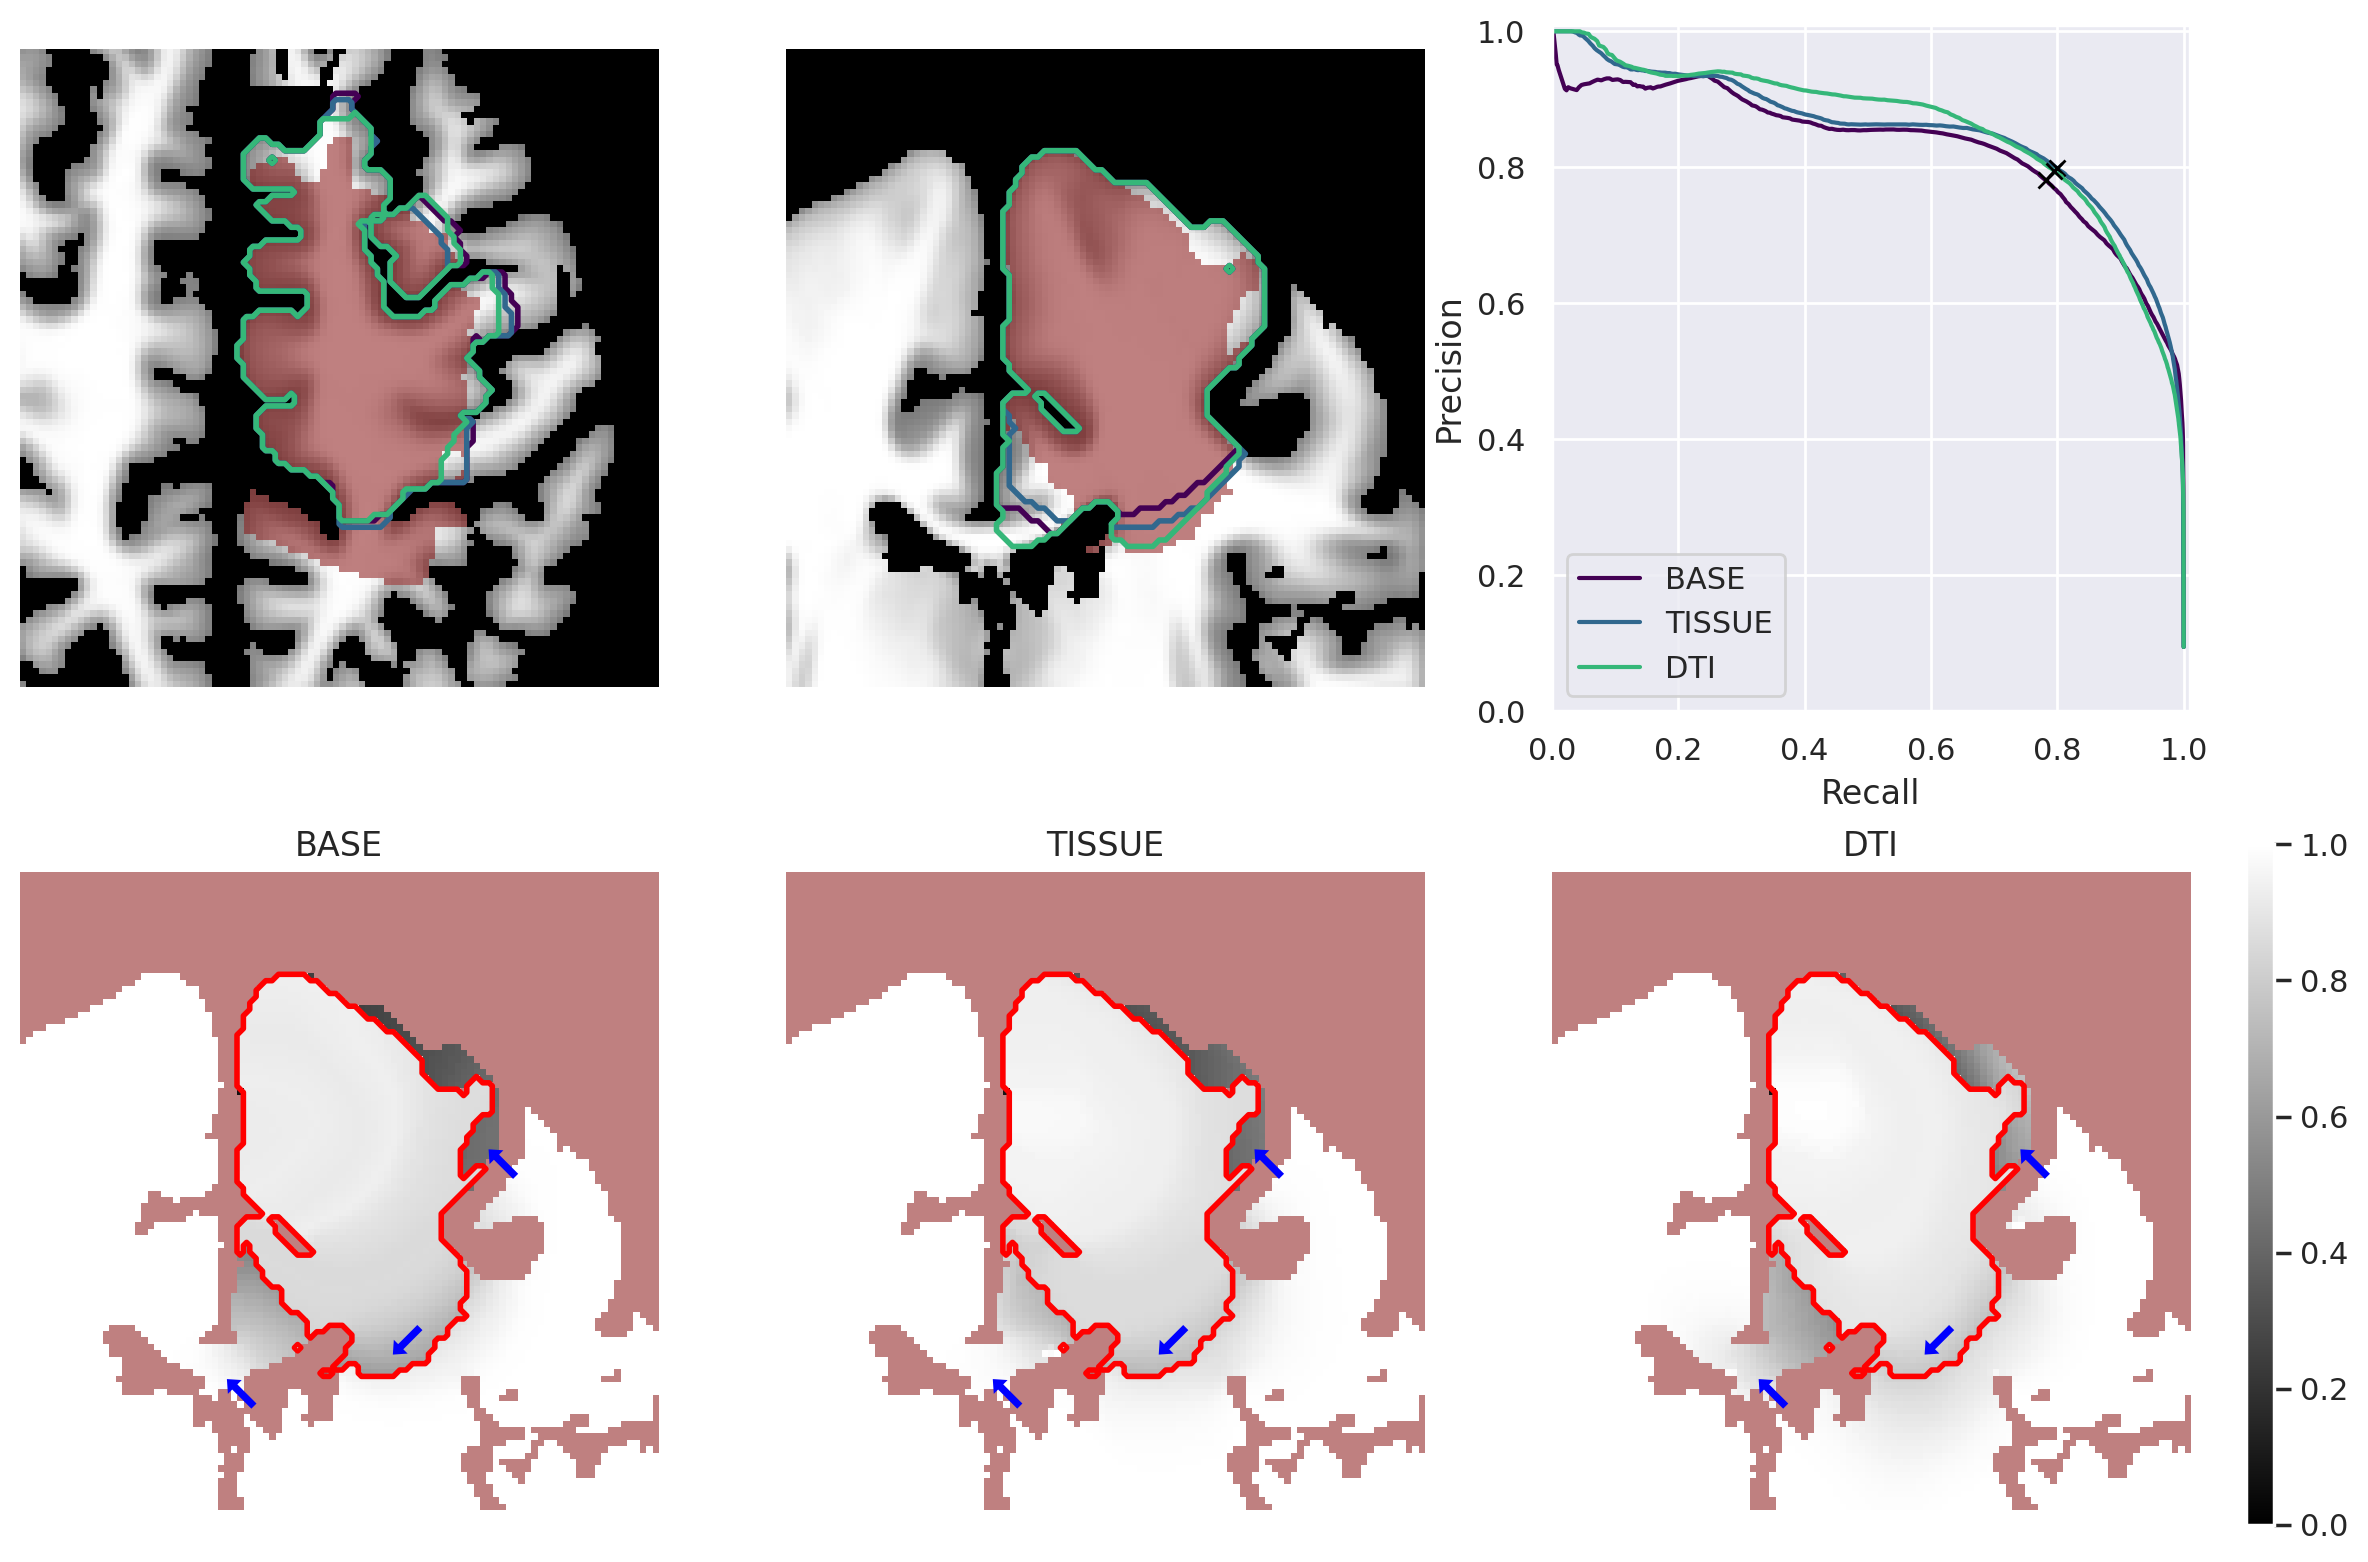

In [40]:
pat_name = 'pat_02'

reference_seg_path = os.path.join(path_dataset, f'{pat_name}/ATLAS/FOLLOWUP_TUMOR_to_atlas_bspline.nii.gz')
reference_seg = sitk.ReadImage(reference_seg_path)
tissue_path = os.path.join(path_dataset, pat_name, 'ATLAS', 'FOLLOWUP_TISSUE_to_atlas_bspline.nii.gz')

background_im_path = '../resources/IITmean_t1.nii.gz'
background_im = sitk.ReadImage(background_im_path)
background_arr = sitk.GetArrayFromImage(background_im)

label_filter = sitk.LabelShapeStatisticsImageFilter()
label_filter.Execute(reference_seg > 0.5)
centroid = label_filter.GetCentroid(1)
index = reference_seg.TransformPhysicalPointToIndex(centroid)

axs = None

norm = mcolors.Normalize(vmin=0, vmax=3)
colors = [cm.viridis(norm(i)) for i in range(3)]

fig, axs = plt.subplots(2,3, figsize=(14,10))

plot_background = True
models = ['BASE', 'TISSUE', 'DTI']

for i in range(0,3):
    model = models[i]
    c = colors[i]

    prediction_path = os.path.join(path_dataset, f'{pat_name}/{model}/')
    tti_arr, reference_arr, inclusion_mask = get_evaluation_data_from_paths(prediction_path, reference_seg_path, tissue_path=tissue_path)
    reference_arr[inclusion_mask < 0.5] = 0
    ## Apply inclusion mask on ranking to make sure local precision / recall matches PR curve
    tti_arr[inclusion_mask < 0.5] = np.max(tti_arr)
    prediction_array_inverted = 0 - tti_arr

    values, reference_values = get_masked_scores(tti_arr, reference_arr, inclusion_mask > 0.5)
    precision, recall, thresholds = get_precision_recall_curve(tti_arr, reference_arr, inclusion_mask > 0.5)

    ap = get_average_precision(tti_arr, reference_arr, inclusion_mask > 0.5)
    dscv = get_dscv(tti_arr, reference_arr, inclusion_mask > 0.5)

    thr_index = np.argwhere(recall>dscv)[-1]
    thr = thresholds[thr_index]
    
    background_arr[inclusion_mask<0.5] = 0

    plot_seg(background_arr, prediction_array_inverted < thr, 
                   reference_arr, index, plot_background=plot_background, axs=axs[0,0], color=[c])
    plot_seg(background_arr, prediction_array_inverted < thr, reference_arr, index, 
             plot_background=plot_background, axs=axs[0,1], color=[c], axial=False)
    plot_background = False

    ### PLOT curve
    axs[0,2].plot(recall, precision, color=c, label=model)
    axs[0,2].plot([dscv], [dscv], 'x', color='black')
    

    prec_arr, recall_arr = get_local_precision_recall(tti_arr, reference_arr, inclusion_mask > 0.5)
    comb_prec_rec = prec_arr
    comb_prec_rec[reference_arr < 0.5] = recall_arr[reference_arr < 0.5]
    plt_axs, map_colorbar = plot_seg(comb_prec_rec, reference_arr, 
                                     inclusion_mask < 0.5, index, axs=axs[1,i], 
                                     color=['red'], norm_background=True, axial=False)
    axs[1,i].set_title(model)
    axs[1,i].arrow(36, 16, -3, 3, width = 0.7, color='blue', head_length=1.2)
    axs[1,i].arrow(77, 52, -3, 3, width = 0.7, color='blue', head_length=1.2)
    axs[1,i].arrow(62, 28, -3, -3, width = 0.7, color='blue', head_length=1.2)

#plt.tight_layout()
axs[0,2].set_xlim(0,1.01)
axs[0,2].set_ylim(0,1.01)
axs[0,2].set_xlabel('Recall')
axs[0,2].set_ylabel('Precision')
axs[0,2].legend()

cb_ax = fig.add_axes([.92,.13,.01,.34])
fig.colorbar(map_colorbar,orientation='vertical',cax=cb_ax)

plt.savefig(f'figures/result_indiv_{pat_name}.jpg',bbox_inches='tight')

plt.show()
plt.close()